Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 2020/2021  
http://www.fer.unizg.hr/predmet/su

------------------------------

### Laboratorijska vježba 4: Procjena parametara, probabilistički grafički modeli i grupiranje

*Verzija: 0.5  
Zadnji put ažurirano: 6. siječnja 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **18. siječnja 2021. u 06:00h**

------------------------------

### Upute

Četvrta laboratorijska vježba sastoji se od tri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno** ili u **tandemu**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [2]:
# Učitaj osnovne biblioteke...
import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import pgmpy as pgm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ftodoric\AppData\Roaming\Python\Python38\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
def plot_silhouette(n_clusters, X):
    # Kôd preuzet s http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.cm.get_cmap("Dark2")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("Vrijednosti koeficijenta siluete")
    ax1.set_ylabel("Oznaka grupe")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = plt.cm.get_cmap("Dark2")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='o', s=30, lw=0, alpha=1,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers # changed to black
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="black", alpha=1, s=100, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=80, edgecolor='k')

    ax2.set_xlabel(r"$x_1$")
    ax2.set_ylabel(r"$x_2$")

    plt.show()

### 1. Procjena maksimalne izglednosti i procjena maksimalne aposteriorne vjerojatnosti

#### (a)

Definirajte funkciju izglednosti $\mathcal{L}(\mu|\mathcal{D})$ za skup $\mathcal{D}=\{x^{(i)}\}_{i=1}^N$ Bernoullijevih varijabli. Neka od $N$ varijabli njih $m$ ima vrijednost 1 (npr. od $N$ bacanja novčića, $m$ puta smo dobili glavu). Definirajte funkciju izglednosti tako da je parametrizirana s $N$ i $m$, dakle definirajte funkciju $\mathcal{L}(\mu|N,m)$. 

In [4]:
def L(mu, N, m):
    return mu**m * (1 - mu)**(N - m)

#### (b)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za (1) $N=10$ i $m=1,2,5,9$ te za (2) $N=100$ i $m=1,10,50,90$ (dva zasebna grafikona).

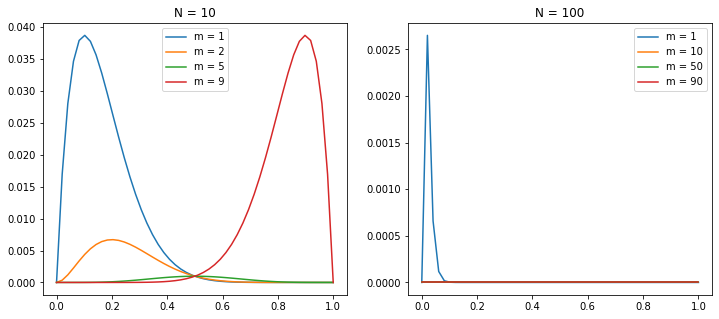

In [5]:
figsize(12, 5)

mu = np.linspace(0, 1, 50)

# Plot 1st graph
plt.subplot(1, 2, 1, title="N = 10")
N = 10
ms = [1, 2, 5, 9]

for m in ms:
    plt.plot(mu, L(mu, N, m), label="m = {}".format(m))
    
plt.legend(loc="best")

# Plot 2nd graph
plt.subplot(1, 2, 2, title="N = 100")
N = 100
ms = [1, 10, 50, 90]
for m in ms:
    plt.plot(mu, L(mu, N, m), label="m = {}".format(m))
    
plt.legend(loc="best")
plt.show()
    

**Q:** Koja vrijednost odgovara ML-procjenama i zašto?

#### (c)

Prikažite funkciju $\mathcal{L}(\mu|N,m)$ za $N=10$ i $m=\{0,9\}$.

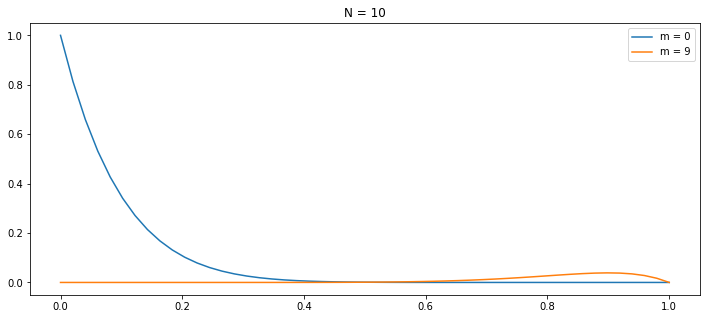

In [6]:
N = 10
ms = [0, 9]

for m in ms:
    plt.plot(mu, L(mu, N, m), label="m = {}".format(m))

plt.title("N = 10")
plt.legend(loc="best")
plt.show()

**Q:** Koja je ML-procjena za $\mu$ i što je problem s takvom procjenom u ovome slučaju?

#### (d)

Prikažite beta-distribuciju $B(\mu|\alpha,\beta)$ za različite kombinacije parametara $\alpha$ i $\beta$, uključivo $\alpha=\beta=1$ te $\alpha=\beta=2$.

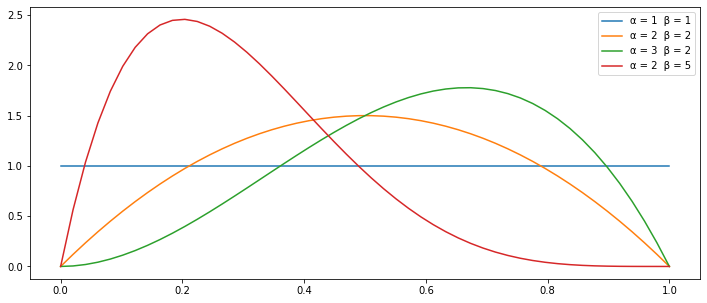

In [8]:
from scipy.stats import beta

alphas = [1, 2, 3, 2]
betas = [1, 2, 2, 5]
for a, b in zip(alphas, betas):
    mu_ml = np.linspace(beta.ppf(0, a, b), beta.ppf(1, a, b), 50)
    plt.plot(mu_ml, beta.pdf(mu_ml, a, b),
             label="\N{GREEK SMALL LETTER ALPHA} = {}  \N{GREEK SMALL LETTER BETA} = {}".format(a, b))

plt.legend(loc="best")
plt.show()

#### (e)

Definirajte funkciju za izračun zajedničke vjerojatnosti $P(\mu,\mathcal{D}) = P(\mathcal{D}|\mu) \cdot P(\mu|\alpha,\beta)$ te prikažite tu funkciju za $N=10$ i $m=9$ i nekolicinu kombinacija parametara $\alpha$ i $\beta$. 

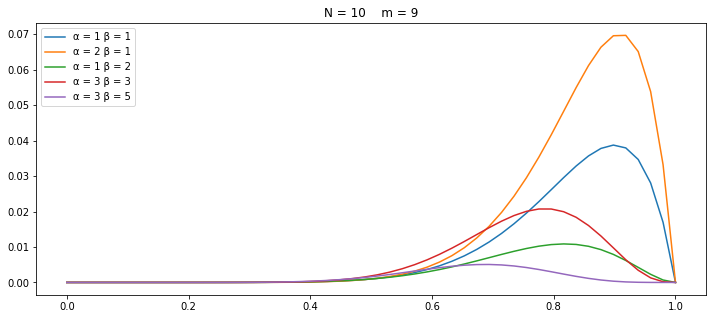

In [9]:
def joint_p(mu, N, m, a, b):
    return L(mu, N, m) * beta.pdf(mu, a, b)

mu = np.linspace(0, 1, 50)
N = 10
m = 9
alphas = [1, 2, 1, 3, 3]
betas = [1, 1, 2, 3, 5]
for a, b in zip(alphas, betas):
    plt.plot(mu, joint_p(mu, N, m, a, b),
             label="\N{GREEK SMALL LETTER ALPHA} = {} \N{GREEK SMALL LETTER BETA} = {}".format(a, b))
    
plt.title("N = 10    m = 9")
plt.legend(loc="best")
plt.show()

**Q**: Koje vrijednosti odgovaraju MAP-procjeni za $\mu$? Usporedite ih sa ML-procjenama.

#### (f)

Za $N=10$ i $m=1$, na jednome grafikonu prikažite sve tri distribucije: $P(\mu,\mathcal{D})$, $P(\mu|\alpha,\beta)$ i $\mathcal{L}(\mu|\mathcal{D})$.

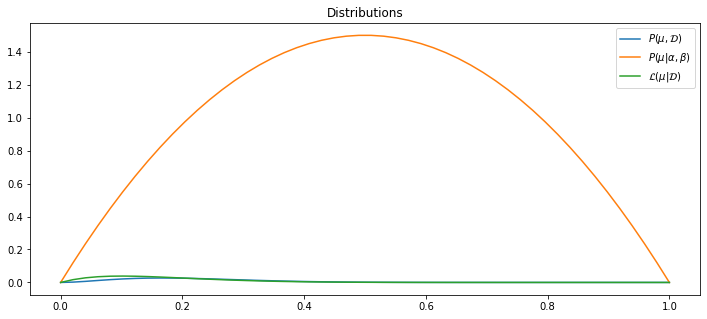

In [13]:
N = 10
m = 1
a = 2
b = 2

plt.title("Distributions")

plt.plot(mu, joint_p(mu, N, m, a, b), label="$P(\mu,\mathcal{D})$")

plt.plot(mu, beta.pdf(mu, a, b), label="$P(\mu|\N{GREEK SMALL LETTER ALPHA}, \N{GREEK SMALL LETTER BETA})$")

plt.plot(mu, L(mu, N, m), label="$\mathcal{L}(\mu|\mathcal{D})$")

plt.legend(loc="best")
plt.show()

#### (g)

Učitajte skup podataka *Iris* korištenjem funkcije [`load_iris`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). Taj skup sadrži $n=4$ značajke i $K=3$ klase. Odaberite jednu klasu i odaberite sve primjere iz te klase, dok ostale primjere zanemarite (**u nastavku radite isključivo s primjerima iz te jedne klase**). Vizualizirajte podatke tako da načinite 2D-prikaze za svaki par značajki (šest grafikona; za prikaz je najjednostavnije koristiti funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter)).

**NB:** Mogla bi Vam dobro dući funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

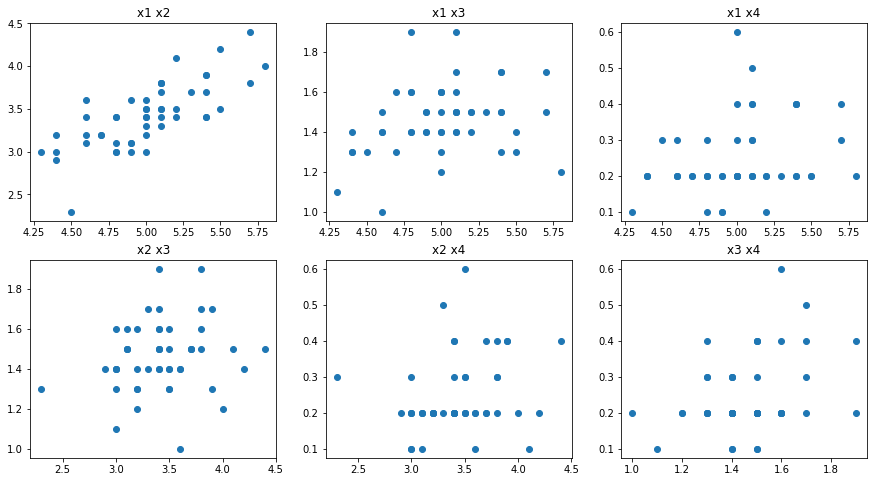

In [21]:
from sklearn.datasets import load_iris
import itertools as it

figsize(15, 8)

iris_data = load_iris()
X_iris = []
y_iris = []

for i in range(len(iris_data.data)):
    if iris_data.target[i] == 0:
        X_iris.append(iris_data.data[i])
        y_iris.append(iris_data.target[i])

plot_data = [[0 for i in range(6)] for i in range(len(X_iris))]
for i, x in enumerate(X_iris):
    plot_pairs = it.combinations(x, 2)
    pairs = []
    for j, pair in enumerate(plot_pairs):
        pairs.append((pair[0], pair[1]))
    plot_data[i] = pairs
    
x_labels = ["x1", "x1", "x1", "x2", "x2", "x3"]
y_labels = ["x2", "x3", "x4", "x3", "x4", "x4"]
for i in range(6):
    plt.subplot(2, 3, i+1)
    x_plot = []
    y_plot = []
    for j in range(len(plot_data)):
        pair = plot_data[j][i]
        x_plot.append(pair[0])
        y_plot.append(pair[1])
    plt.title(x_labels[i] + " " + y_labels[i])
    plt.scatter(x_plot, y_plot)

plt.show()

#### (h)

Pogledajte opis modula [`stats`](http://docs.scipy.org/doc/scipy-0.14.0/reference/stats.html) te proučite funkciju [`norm`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.norm.html#scipy.stats.norm). Implementirajte funkciju log-izglednosti za parametre $\mu$ i $\sigma^2$ normalne distribucije.

In [23]:
from scipy.stats import norm

def logL_normal(x, mi, sigma):
    normal_distribution = norm(mi, sigma)
    return sum(normal_distribution.logpdf(x))

#### (i)
Izračunajte ML-procjene za $(\mu, \sigma^2)$ za svaku od $n=4$ značajki iz skupa *Iris*. Ispišite log-izglednosti tih ML-procjena. 

In [25]:
x1 = []
x2 = []
x3 = []
x4 = []

N = len(X_iris)

# Calculate MLE mean
means = [0 for i in range(len(X_iris[0]))]
for sample in X_iris:
    x1.append(sample[0])
    x2.append(sample[1])
    x3.append(sample[2])
    x4.append(sample[3])
    
    for i in range(len(sample)):
        means[i] += sample[i]

for i in range(len(means)):
    means[i] = means[i]/N          

# Calculate MLE variance
variances = [0 for i in range(len(X_iris[0]))]
for sample in X_iris:
    for i in range(len(sample)):
        variances[i] += (sample[i] - means[i])**2
    
for i in range(len(means)):
    variances[i] = variances[i]/N

features = [x1, x2, x3, x4]
for i in range(len(means)):
    print("x{}: \N{greek small letter mu} = {:.3f}  \N{greek small letter sigma}\N{superscript two} = {:.3f}  logL = {:.4f}"
          .format(i + 1, means[i], variances[i],
                  logL_normal(features[i], means[i], (variances[i])**(1/2))))

x1: μ = 5.006  σ² = 0.122  logL = -18.3052
x2: μ = 3.428  σ² = 0.141  logL = -21.9394
x3: μ = 1.462  σ² = 0.030  logL = 17.0898
x4: μ = 0.246  σ² = 0.011  logL = 42.0646


#### (j)

Proučite funkciju [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) za izračun Pearsonovog koeficijenta korelacije. Izračunajte koeficijente korelacije između svih četiri značajki u skupu *Iris*. 

In [26]:
from scipy.stats import pearsonr

print("Pearson Correlation Coefficients:")
for i in range(len(features)):
    for j in range(len(features)):
        print("r(x{}, x{}) = {:.3f}"
              .format(i + 1, j + 1, pearsonr(features[i], features[j])[0]), end="  ")
    print()

Pearson Correlation Coefficients:
r(x1, x1) = 1.000  r(x1, x2) = 0.743  r(x1, x3) = 0.267  r(x1, x4) = 0.278  
r(x2, x1) = 0.743  r(x2, x2) = 1.000  r(x2, x3) = 0.178  r(x2, x4) = 0.233  
r(x3, x1) = 0.267  r(x3, x2) = 0.178  r(x3, x3) = 1.000  r(x3, x4) = 0.332  
r(x4, x1) = 0.278  r(x4, x2) = 0.233  r(x4, x3) = 0.332  r(x4, x4) = 1.000  


#### (k)

Proučite funkciju [`cov`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html) te izračunajte ML-procjenu za kovarijacijsku matricu za skup *Iris*. Usporedite pristranu i nepristranu procjenu. Pokažite da se razlika (srednja apsolutna i kvadratna) smanjuje s brojem primjera (npr. isprobajte za $N/4$ i $N/2$ i $N$ primjera).

In [27]:
print("ML Biased Covariance Matrix (X_iris) =\n{}".format(cov(X_iris, bias=True, rowvar=False)))
print()
print("ML Unbiased Covariance Matrix (X_iris) =\n{}".format(cov(X_iris, bias=False, rowvar=False)))

def mean_squared_difference(sigma_biased, sigma_unbiased):
    difference_matrix = sigma_biased - sigma_unbiased
    msd = 0
    for i in range(len(difference_matrix)):
        for j in range(len(difference_matrix[0])):
            msd += difference_matrix[i][j]**2
    return msd

def mean_absolute_difference(sigma_biased, sigma_unbiased):
    difference_matrix = sigma_biased - sigma_unbiased
    mad = 0
    for i in range(len(difference_matrix)):
        for j in range(len(difference_matrix[0])):
            mad += abs(difference_matrix[i][j])
    return mad

print()

scale_factors = [1/4, 1/2, 1]
for f in scale_factors:
    sigma_biased = cov(X_iris[0:int(f*len(X_iris))], bias=True, rowvar=False)
    sigma_unbiased = cov(X_iris[0:int(f*len(X_iris))], bias=False, rowvar=False)
    print("For {}*N:\tMean Square Diff = {:.6f}\tMean Absolute Diff = {:.6f}"
          .format(f,
                  mean_squared_difference(sigma_biased, sigma_unbiased),
                  mean_absolute_difference(sigma_biased, sigma_unbiased)))

ML Biased Covariance Matrix (X_iris) =
[[0.121764 0.097232 0.016028 0.010124]
 [0.097232 0.140816 0.011464 0.009112]
 [0.016028 0.011464 0.029556 0.005948]
 [0.010124 0.009112 0.005948 0.010884]]

ML Unbiased Covariance Matrix (X_iris) =
[[0.12424898 0.09921633 0.0163551  0.01033061]
 [0.09921633 0.1436898  0.01169796 0.00929796]
 [0.0163551  0.01169796 0.03015918 0.00606939]
 [0.01033061 0.00929796 0.00606939 0.01110612]]

For 0.25*N:	Mean Square Diff = 0.000207	Mean Absolute Diff = 0.038384
For 0.5*N:	Mean Square Diff = 0.000123	Mean Absolute Diff = 0.029589
For 1*N:	Mean Square Diff = 0.000023	Mean Absolute Diff = 0.012303


### 2. Probabilistički grafički modeli -- Bayesove mreže

Ovaj zadatak bavit će se Bayesovim mrežama, jednim od poznatijih probabilističkih grafičkih modela (*probabilistic graphical models*; PGM). Za lakše eksperimentiranje koristit ćemo programski paket [`pgmpy`](https://github.com/pgmpy/pgmpy). Molimo Vas da provjerite imate li ovaj paket te da ga instalirate ako ga nemate. Upute se nalaze na gornjoj poveznici. Za korisnike Anaconde, najlakše je upisati `conda install -c ankurankan pgmpy` (ili `pip install pgmpy` ako ne prolazi) unutar Anaconda Prompta (i ponovno pokrenuti Jupyter).

#### (a)  
Prvo ćemo pogledati udžbenički primjer s prskalicom. U ovom primjeru razmatramo Bayesovu mrežu koja modelira zavisnosti između oblačnosti (slučajna varijabla $C$), kiše ($R$), prskalice ($S$) i mokre trave ($W$). U ovom primjeru također pretpostavljamo da već imamo parametre vjerojatnosnih distribucija svih čvorova. Ova mreža prikazana je na sljedećoj slici:

![This](http://www.fer.unizg.hr/_download/repository/bayes-net-sprinkler.jpg)

Koristeći paket `pgmpy`, konstruirajte Bayesovu mrežu iz gornjeg primjera. Zatim, koristeći **egzaktno** zaključivanje, postavite sljedeće posteriorne upite: $P(w=1)$, $P(s=1|w=1)$, $P(r=1|w=1)$, $P(c=1|s=1, r=1)$ i $P(c=1)$. Provedite zaključivanje na papiru i uvjerite se da ste ispravno konstruirali mrežu. Pomoći će vam službena dokumentacija te primjeri korištenja (npr. [ovaj](https://github.com/pgmpy/pgmpy/blob/dev/examples/Monty%20Hall%20Problem.ipynb)).

In [20]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination

In [21]:
# Defining the network structure
sprinkler_model = BayesianModel([('C', 'S'),
                                 ('C', 'R'),
                                 ('S', 'W'),
                                 ('R','W')])
# Defining the CPDs:
cpd_c = TabularCPD('C', 2, [[0.50], [0.50]])
cpd_s = TabularCPD('S', 2, [[0.50, 0.90],
                            [0.50, 0.10]],
                   evidence=['C'], evidence_card=[2])
cpd_r = TabularCPD('R', 2, [[0.80, 0.20],
                            [0.20, 0.80]],
                   evidence=['C'], evidence_card=[2])
cpd_w = TabularCPD('W', 2, [[1.00, 0.10, 0.10, 0.01],
                            [0.00, 0.90, 0.90, 0.99]],
                   evidence=['S', 'R'], evidence_card=[2, 2])

# Associating the CPDs with the network structure
sprinkler_model.add_cpds(cpd_c, cpd_s, cpd_r, cpd_w)

# Exact inference
infer = VariableElimination(sprinkler_model)

# Posterior Queries
posterior_p = infer.query(['W'], evidence={}, show_progress=False)
print("P(w = 1) = {:.4f}".format(posterior_p.values[1]))

posterior_p = infer.query(['S'], evidence={'W': 1}, show_progress=False)
print("P(s = 1 | w = 1) = {:.4f}".format(posterior_p.values[1]))

posterior_p = infer.query(['R'], evidence={'W': 1}, show_progress=False)
print("P(r = 1 | w = 1) = {:.4f}".format(posterior_p.values[1]))

posterior_p = infer.query(['C'], evidence={'S': 1, 'R': 1}, show_progress=False)
print("P(c = 1 | s = 1, r = 1) = {:.4f}".format(posterior_p.values[1]))

posterior_p = infer.query(['C'], evidence={}, show_progress=False)
print("P(c = 1) = {:.4f}".format(posterior_p.values[1]))

P(w = 1) = 0.6471
P(s = 1 | w = 1) = 0.4298
P(r = 1 | w = 1) = 0.7079
P(c = 1 | s = 1, r = 1) = 0.4444
P(c = 1) = 0.5000


**Q:** Koju zajedničku vjerojatnosnu razdiobu ova mreža modelira? Kako tu informaciju očitati iz mreže?  
**Q:** U zadatku koristimo egzaktno zaključivanje. Kako ono radi?  
**Q:** Koja je razlika između posteriornog upita i MAP-upita?  
**Q:** Zašto je vjerojatnost $P(c=1)$ drugačija od $P(c=1|s=1,r=1)$ ako znamo da čvorovi $S$ i $R$ nisu roditelji čvora $C$?

#### (b)  
**Efekt objašnjavanja** (engl. *explaining away*) zanimljiv je fenomen u kojem se događa da se dvije varijable "natječu" za objašnjavanje treće. Ovaj fenomen može se primijetiti na gornjoj mreži. U tom se slučaju varijable prskalice ($S$) i kiše ($R$) "natječu" za objašnjavanje mokre trave ($W$). Vaš zadatak je pokazati da se fenomen zaista događa.

In [22]:
posterior_p = infer.query(['S'], evidence={'W': 1}, show_progress=False)
print("P(s = 1 | w = 1) = {:.4f}".format(posterior_p.values[1]))

posterior_p = infer.query(['S'], evidence={'W': 1, 'R': 1}, show_progress=False)
print("P(s = 1 | w = 1, r = 1) = {:.4f}".format(posterior_p.values[1]))

P(s = 1 | w = 1) = 0.4298
P(s = 1 | w = 1, r = 1) = 0.1945


**Q:** Kako biste svojim riječima opisali ovaj fenomen, koristeći se ovim primjerom?

### 3. Grupiranje

U ovom zadatku ćete se upoznati s algoritmom k-sredina (engl. *k-means*), njegovim glavnim nedostatcima te pretpostavkama. Također ćete isprobati i drugi algoritam grupiranja: model Gaussovih mješavina (engl. *Gaussian mixture model*).

#### (a)  
Jedan od nedostataka algoritma k-sredina jest taj što unaprijed zahtjeva broj grupa ($K$) u koje će grupirati podatke. Ta informacija nam često nije dostupna (kao što nam nisu dostupne ni oznake primjera) te je stoga potrebno nekako izabrati najbolju vrijednost hiperparametra $K$. Jedan od naivnijih pristupa jest **metoda lakta/koljena** (engl. *elbow method*) koju ćete isprobati u ovom zadatku.

U svojim rješenjima koristite ugrađenu implementaciju algoritma k-sredina, dostupnoj u razredu [`cluster.KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html). 

**NB**: Kriterijska funkcija algoritma k-sredina još se i naziva **inercijom** (engl. *inertia*). Za naučeni model, vrijednost kriterijske funkcije $J$ dostupna je kroz razredni atribut `inertia_`.

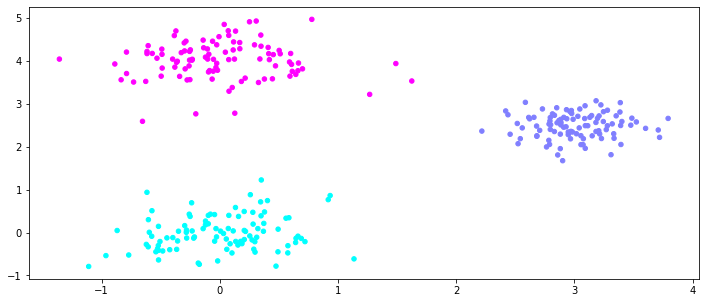

In [24]:
from sklearn.datasets import make_blobs

Xp, yp = make_blobs(n_samples=300, n_features=2, centers=[[0, 0], [3, 2.5], [0, 4]], 
                    cluster_std=[0.45, 0.3, 0.45], random_state=96)
plt.scatter(Xp[:,0], Xp[:,1], c=yp, cmap=plt.get_cmap("cool"), s=20)
plt.show()

Iskoristite skup podataka `Xp` dan gore. Isprobajte vrijednosti hiperparametra $K$ iz $[0,1,\ldots,15]$. Ne trebate dirati nikakve hiperparametre modela osim $K$. Iscrtajte krivulju od $J$ u ovisnosti o broju grupa $K$. Metodom lakta/koljena odredite vrijednost hiperparametra $K$.

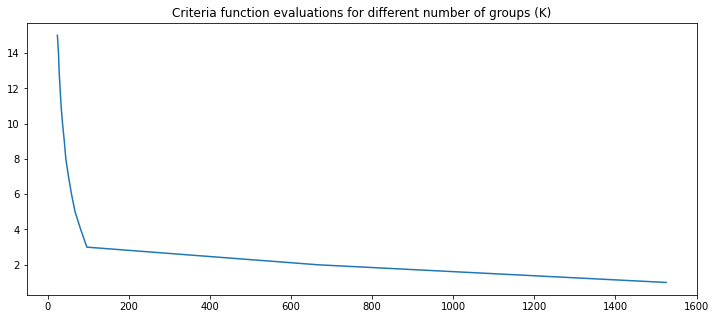

In [25]:
from sklearn.cluster import KMeans

Ks = [i for i in range(1, 16)]

Js = []
for K in Ks:
    kmeans_model = KMeans(n_clusters=K).fit(Xp)
    Js.append(kmeans_model.inertia_)

plt.title("Criteria function evaluations for different number of groups (K)")
plt.plot(Js, Ks)
plt.show()

**Q:** Koju biste vrijednost hiperparametra $K$ izabrali na temelju ovog grafa? Zašto? Je li taj odabir optimalan? Kako to znate?    
**Q:** Je li ova metoda robusna?  
**Q:** Možemo li izabrati onaj $K$ koji minimizira pogrešku $J$? Objasnite.

#### (b)  
Odabir vrijednosti hiperparametra $K$ može se obaviti na mnoštvo načina. Pored metode lakta/koljena, moguće je isto ostvariti i analizom siluete (engl. *silhouette analysis*). Za to smo pripremili funkciju `plot_silhouette` koja za dani broj grupa i podatke iscrtava prosječnu vrijednost koeficijenta siluete i vrijednost koeficijenta svakog primjera (kroz grupe). 

Vaš je zadatak isprobati različite vrijednosti hiperparametra $K$, $K \in \{2, 3, 5\}$ i na temelju dobivenih grafova odlučiti se za optimalan $K$.

For n_clusters = 2 The average silhouette_score is : 0.59280796169837


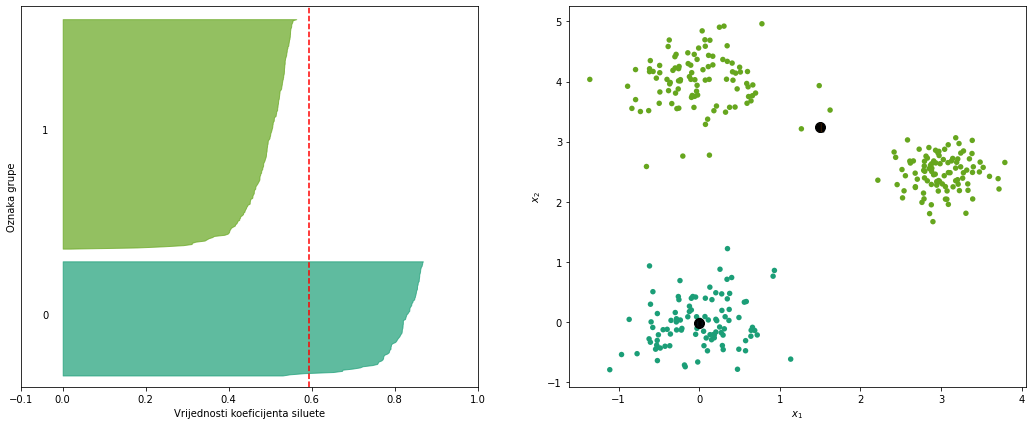

For n_clusters = 3 The average silhouette_score is : 0.7975462212061406


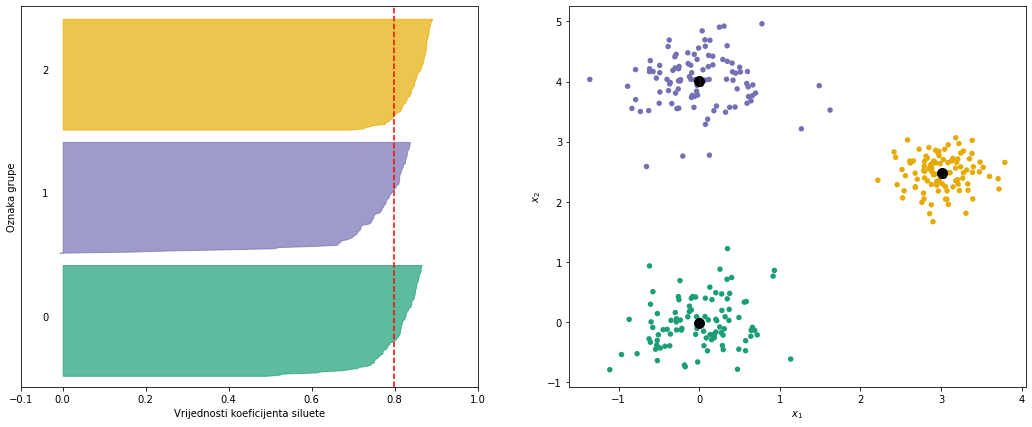

For n_clusters = 5 The average silhouette_score is : 0.5059026123508755


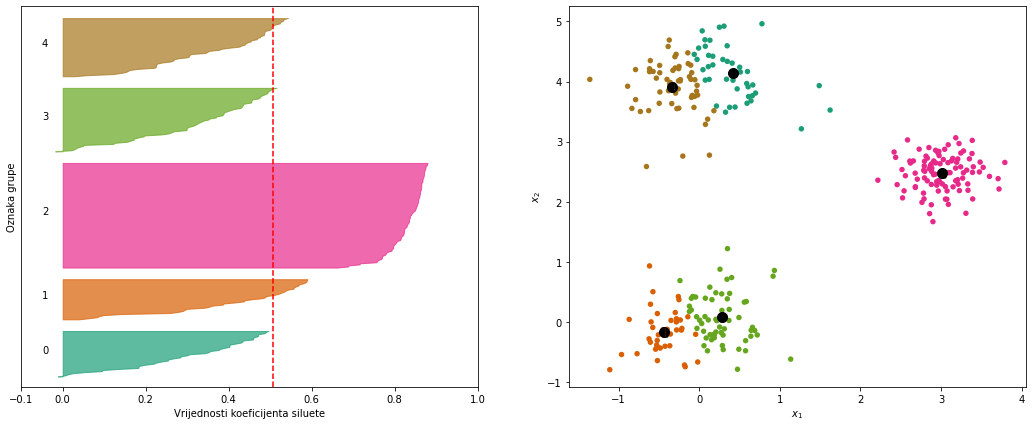

In [26]:
Ks = [2, 3, 5]

for K in Ks:
    plot_silhouette(K, Xp)

**Q:** Kako biste se gledajući ove slike odlučili za $K$?  
**Q:** Koji su problemi ovog pristupa?

#### (c)  
U ovom i sljedećim podzadatcima fokusirat ćemo se na temeljne pretpostavke algoritma k-sredina te što se događa ako te pretpostavke nisu zadovoljene. Dodatno, isprobat ćemo i grupiranje modelom Gaussovih mješavina (engl. *Gaussian Mixture Models*; GMM) koji ne nema neke od tih pretpostavki.

Prvo, krenite od podataka `X1`, koji su generirani korištenjem funkcije [`datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html), koja stvara grupe podataka pomoću izotropskih Gaussovih distribucija.

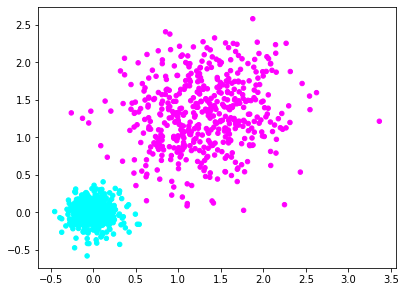

In [27]:
from sklearn.datasets import make_blobs

figsize(6.4, 4.8)

X1, y1 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0], [1.3, 1.3]], cluster_std=[0.15, 0.5], random_state=96)
plt.scatter(X1[:,0], X1[:,1], c=y1, cmap=plt.get_cmap("cool"), s=20)
plt.show()

Naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

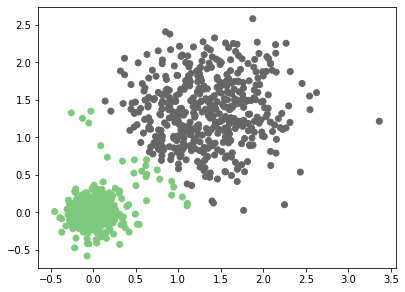

In [28]:
kmeans_model_c = KMeans(n_clusters=2).fit(X1)
plt.scatter(X1[:,0], X1[:,1], c=kmeans_model_c.labels_, cmap="Accent")
plt.show()

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (d)

Isprobajte algoritam k-sredina na podatcima generiranim korištenjem funkcije [`datasets.make_circles`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), koja stvara dvije grupe podataka tako da je jedna unutar druge.

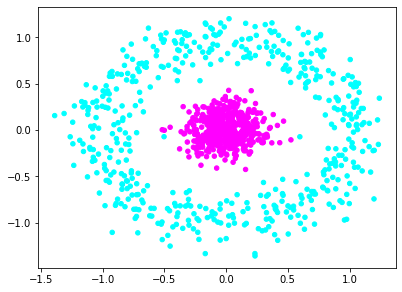

In [29]:
from sklearn.datasets import make_circles

X2, y2 = make_circles(n_samples=1000, noise=0.15, factor=0.05, random_state=96)
plt.scatter(X2[:,0], X2[:,1], c=y2, cmap=plt.get_cmap("cool"), s=20)
plt.show()

Ponovno, naučite model k-sredina (idealno pretpostavljajući $K=2$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

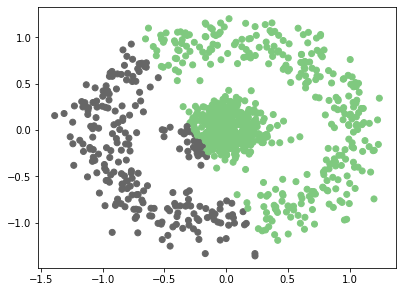

In [30]:
kmeans_model_d = KMeans(n_clusters=2).fit(X2)
plt.scatter(X2[:,0], X2[:,1], c=kmeans_model_d.labels_, cmap="Accent")
plt.show()

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (e)  
Završno, isprobat ćemo algoritam na sljedećem umjetno stvorenom skupu podataka:

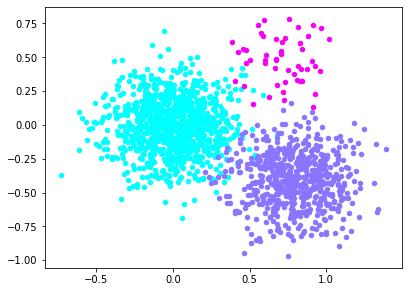

In [31]:
X31, y31 = make_blobs(n_samples=1000, n_features=2, centers=[[0, 0]], cluster_std=[0.2], random_state=69)
X32, y32 = make_blobs(n_samples=50, n_features=2, centers=[[0.7, 0.5]], cluster_std=[0.15], random_state=69)
X33, y33 = make_blobs(n_samples=600, n_features=2, centers=[[0.8, -0.4]], cluster_std=[0.2], random_state=69)
plt.scatter(X31[:,0], X31[:,1], c="#00FFFF", s=20)
plt.scatter(X32[:,0], X32[:,1], c="#F400F4", s=20)
plt.scatter(X33[:,0], X33[:,1], c="#8975FF", s=20)

# Just join all the groups in a single X.
X3 = np.vstack([X31, X32, X33])
y3 = np.hstack([y31, y32, y33])

Ponovno, naučite model k-sredina (ovaj put idealno pretpostavljajući $K=3$) na gornjim podatcima i prikažite dobiveno grupiranje (proučite funkciju [`scatter`](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter), posebice argument `c`).

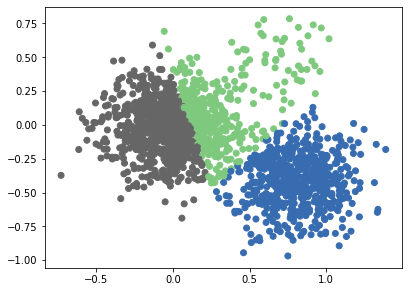

In [32]:
kmeans_model_e = KMeans(n_clusters=3).fit(X3)
plt.scatter(X3[:,0], X3[:,1], c=kmeans_model_e.labels_, cmap="Accent")
plt.show()

**Q:** Što se dogodilo? Koja je pretpostavka algoritma k-sredina ovdje narušena?  
**Q:** Što biste morali osigurati kako bi algoritam pronašao ispravne grupe?

#### (f)  
Sada kada ste se upoznali s ograničenjima algoritma k-sredina, isprobat ćete grupiranje modelom mješavine Gaussa (*Gaussian Mixture Models; GMM*), koji je generalizacija algoritma k-sredina (odnosno, algoritam k-sredina specijalizacija je GMM-a). Implementacija ovog modela dostupna je u [`mixture.GaussianMixture`](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html). Isprobajte ovaj model (s istim pretpostavkama o broju grupa) na podacima iz podzadataka (c)-(e). Ne morate mijenjati nikakve hiperparametre ni postavke osim broja komponenti.

In [33]:
from sklearn.mixture import GaussianMixture

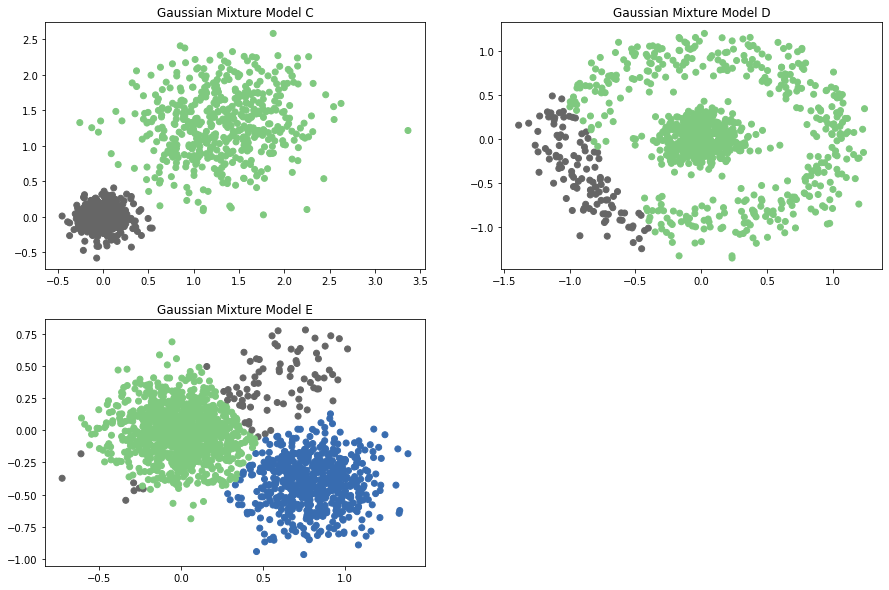

In [35]:
figsize(15, 10)

gaussian_mixture_model_c = GaussianMixture(n_components=2).fit(X1)
plt.subplot(2, 2, 1, title="Gaussian Mixture Model C")
plt.scatter(X1[:,0], X1[:,1], c=gaussian_mixture_model_c.predict(X1), cmap="Accent")

gaussian_mixture_model_d = GaussianMixture(n_components=2).fit(X2)
plt.subplot(2, 2, 2, title="Gaussian Mixture Model D")
plt.scatter(X2[:,0], X2[:,1], c=gaussian_mixture_model_d.predict(X2), cmap="Accent")

gaussian_mixture_model_e = GaussianMixture(n_components=3).fit(X3)
plt.subplot(2, 2, 3, title="Gaussian Mixture Model E")
plt.scatter(X3[:,0], X3[:,1], c=gaussian_mixture_model_e.predict(X3), cmap="Accent")

plt.show()

#### (g)  
Kako vrednovati točnost modela grupiranja ako imamo stvarne oznake svih primjera (a u našem slučaju imamo, jer smo mi ti koji smo generirali podatke)? Često korištena mjera jest **Randov indeks** koji je zapravo pandan točnosti u zadatcima klasifikacije. Implementirajte funkciju `rand_index_score(y_gold, y_predict)` koja ga računa. Funkcija prima dva argumenta: listu stvarnih grupa kojima primjeri pripadaju (`y_gold`) i listu predviđenih grupa (`y_predict`). Dobro će vam doći funkcija [`itertools.combinations`](https://docs.python.org/2/library/itertools.html#itertools.combinations).

In [36]:
import itertools as it

def rand_index_score(y_gold, y_predict):
    TP = 0
    TN = 0
    
    for i in range(len(y_gold)):
        for j in range(i + 1, len(y_gold)):
            # If they're in the same group
            if y_gold[i] == y_gold[j]:
                # And supposed to be
                if y_predict[i] == y_predict[j]:
                    TP += 1
            # If they're not in the same group
            else:
                # And not supposed to be
                if y_predict[i] != y_predict[j]:
                    TN += 1
    
    NC2 = len(tuple(it.combinations(y_predict, 2)))
    
    return (TP + TN) / NC2
    
print("rand(KMeans Model C) = {}".format(rand_index_score(y1, kmeans_model_c.labels_)))
print("rand(KMeans Model D) = {}".format(rand_index_score(y2, kmeans_model_d.labels_)))
print("rand(KMeans Model E) = {}".format(rand_index_score(y3, kmeans_model_e.labels_)))
print()
print("rand(Gaussian Mixture Model C) = {}".format(rand_index_score(y1, gaussian_mixture_model_c.predict(X1))))
print("rand(Gaussian Mixture Model D) = {}".format(rand_index_score(y2, gaussian_mixture_model_d.predict(X2))))
print("rand(Gaussian Mixture Model E) = {}".format(rand_index_score(y3, gaussian_mixture_model_e.predict(X3))))

rand(KMeans Model C) = 0.9531051051051052
rand(KMeans Model D) = 0.5622202202202202
rand(KMeans Model E) = 0.3519738317070033

rand(Gaussian Mixture Model C) = 1.0
rand(Gaussian Mixture Model D) = 0.525063063063063
rand(Gaussian Mixture Model E) = 0.4780667806016502


**Q:** Zašto je Randov indeks pandan točnosti u klasifikacijskim problemima?  
**Q:** Koji su glavni problemi ove metrike?   
**Q:** Kako vrednovati kvalitetu grupiranja ako nenamo stvarne oznake primjera? Je li to uopće moguće?